In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip /content/drive/MyDrive/dataset.zip -d /content

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005001.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005002.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005003.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005004.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005005.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005006.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005007.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005008.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005009.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005010.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005011.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005012.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005013.jpg  
  inflating: /content/dataset/StyleGAN2/SFHQ_pt4_00005014.jpg  
  inflating: /content/dataset/StyleG

In [ ]:
import os
import pandas as pd
from PIL import Image

In [ ]:
data = {'img':[], 'label':[], }
path = '/content/dataset'
folder = os.listdir(path)
class_name = {'real':0, 'StyleGAN':1, 'StyleGAN2':2}

for target in folder:
  images = os.listdir(path +'/'+target)
  cnt = 0
  for image in images:
    data['img'].append(Image.open(path +'/'+target + '/' +image))
    data['label'].append(class_name[target])
    cnt += 1
    if cnt == 2000:
      break

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['img'], data['label'], test_size=0.20, random_state=42, shuffle=True)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42, shuffle=True)

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset
import numpy as np
import matplotlib.pyplot as plt
import copy
class MyDataset(Dataset):
    def __init__(self, data, targets,transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

normalize = Normalize(mean=mean, std=std)
_train_transforms = Compose(
        [
            RandomResizedCrop(224),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(224),
            CenterCrop(224),
            ToTensor(),
            normalize,
        ]
    )

In [ ]:
train_set = MyDataset(X_train,y_train, transform=_train_transforms)
trainloader = DataLoader(train_set, batch_size=16, shuffle=True)

test_set = MyDataset(X_test,y_test, transform=_val_transforms)
testloader = DataLoader(test_set, batch_size=1)

val_set =  MyDataset(X_val,y_val, transform=_val_transforms)
valloader = DataLoader(val_set, batch_size=16)

In [ ]:
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import os
import random

model = models.vgg19(weights='DEFAULT')
model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 94.7MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 3)]) # Add our layer with 4 outputs
model.classifier = nn.Sequential(*features)
model = model.to('cuda')

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.0002, momentum=0.9)
criterion = nn.CrossEntropyLoss()
num_epochs = 10
dataloaders = {'train':trainloader, 'val':valloader}

In [ ]:
dataloader = {
    'train':trainloader,
    'val':valloader
}

In [ ]:
def train_model(model, dataloaders, optimizer, criterion=criterion, num_epochs=10):
    start = time.time()
    val_acc_history = []

    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0

    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to('cuda')
                labels = labels.to('cuda')
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                val_loss_history.append(epoch_loss)

    time_elapsed = time.time()

    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Best model weights are loaded here
    model.load_state_dict(best_model_weights)
    return model, val_acc_history, train_loss_history, val_loss_history

In [ ]:
model, val_acc_history, train_loss_history, val_loss_history = train_model(model, dataloader, optimizer, criterion, num_epochs)

Epoch 0/9
----------
train Loss: 0.7239 Acc: 0.6292
val Loss: 0.5793 Acc: 0.7208
Epoch 1/9
----------
train Loss: 0.4417 Acc: 0.7697
val Loss: 0.6030 Acc: 0.7063
Epoch 2/9
----------
train Loss: 0.3927 Acc: 0.8104
val Loss: 0.3172 Acc: 0.8583
Epoch 3/9
----------
train Loss: 0.3492 Acc: 0.8301
val Loss: 0.3326 Acc: 0.8667
Epoch 4/9
----------
train Loss: 0.3097 Acc: 0.8532
val Loss: 0.2343 Acc: 0.9062
Epoch 5/9
----------
train Loss: 0.2690 Acc: 0.8799
val Loss: 0.2592 Acc: 0.8896
Epoch 6/9
----------
train Loss: 0.2338 Acc: 0.8965
val Loss: 0.2962 Acc: 0.8917
Epoch 7/9
----------
train Loss: 0.2004 Acc: 0.9141
val Loss: 0.1809 Acc: 0.9250
Epoch 8/9
----------
train Loss: 0.1984 Acc: 0.9176
val Loss: 0.3320 Acc: 0.8542
Epoch 9/9
----------
train Loss: 0.1908 Acc: 0.9192
val Loss: 0.1443 Acc: 0.9437
Training complete in 28590399m 6s
Best val Acc: 0.943750


In [ ]:
import numpy as np

def plot_training_history(train_loss_history, val_loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')

    # Calculate the average losses
    average_train_loss = np.mean(train_loss_history)
    average_val_loss = np.mean(val_loss_history)

    # Display average losses on the plot
    plt.axhline(y=average_train_loss, color='r', linestyle='--', label=f'Average Training Loss: {average_train_loss:.4f}')
    plt.axhline(y=average_val_loss, color='b', linestyle='--', label=f'Average Validation Loss: {average_val_loss:.4f}')

    plt.title('Training and Validation Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

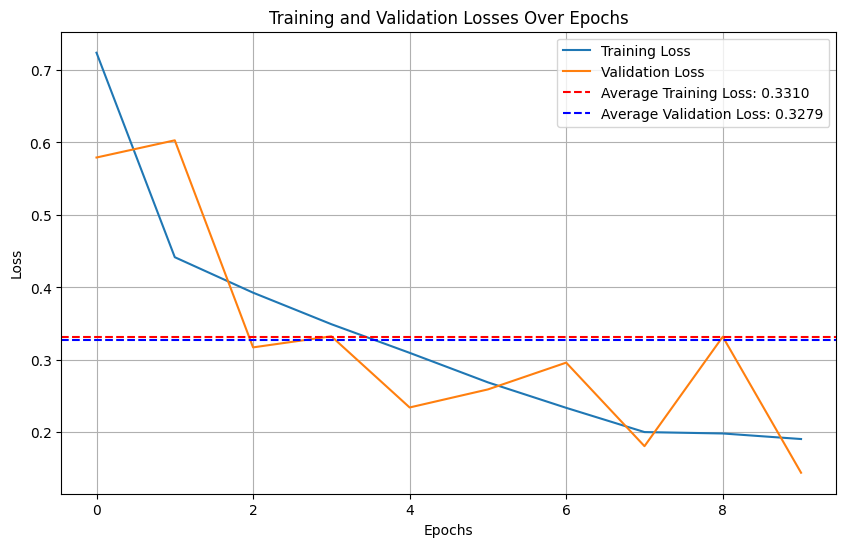

In [ ]:
plot_training_history(train_loss_history, val_loss_history)

Test Loss: 0.2191
Precision: 0.9101, Recall: 0.9104, F1 Score: 0.9064
Incorrectly Labeled: 114/1200 (9.50%)


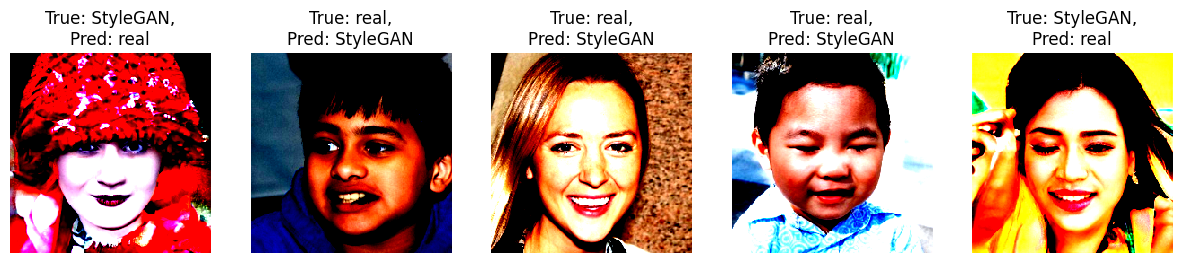

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       437
           1       0.81      0.94      0.87       380
           2       0.98      1.00      0.99       383

    accuracy                           0.91      1200
   macro avg       0.91      0.91      0.91      1200
weighted avg       0.91      0.91      0.90      1200



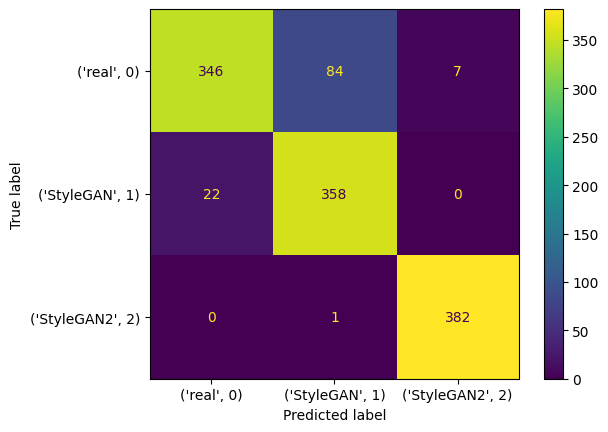

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def test_model(model, dataloader, criterion, show_images=False, num_images=10):
    name_lookup = {v: k for k, v in class_name.items()}

    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_samples = 0
    all_preds = []
    all_labels = []
    incorrect_samples = []
    incorrect_count = 0


    # No need to track gradients for testing
    with torch.no_grad():
        for inputs, labels in dataloader:

            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Collect incorrect samples
            misclassified_indices = (preds != labels).nonzero().flatten()
            incorrect_count += len(misclassified_indices)
            for index in misclassified_indices:
                incorrect_samples.append((inputs[index], labels[index].item(), preds[index].item()))

    # Calculate metrics
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f'Test Loss: {total_loss / total_samples:.4f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    print(f'Incorrectly Labeled: {incorrect_count}/{total_samples} ({incorrect_count/total_samples*100:.2f}%)')

    if show_images and incorrect_samples:
        # Display first few misclassified images
        fig, axes = plt.subplots(1, min(num_images, len(incorrect_samples)), figsize=(15, 3))
        for i, (img, true, pred) in enumerate(incorrect_samples[:num_images]):
            ax = axes[i] if num_images > 1 else axes
            img = img.cpu().numpy().transpose((1, 2, 0))  # Assuming image tensor format: CxHxW
            img = np.clip(img, 0, 1)
            ax.imshow(img, interpolation='nearest')
            ax.set_title(f'True: {name_lookup[true]},\nPred: {name_lookup[pred]}')
            ax.axis('off')
        plt.show()

    return total_loss / total_samples, precision, recall, f1, all_labels, all_preds

#отдельный блок
test_loss, test_precision, test_recall, test_f1, all_labels, all_preds = test_model(model, testloader, criterion, show_images=True, num_images=5)

#отдельный блок
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
confusion_matrix(all_labels, all_preds)
#отдельный блок
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds))
#отдельный блок
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(all_labels, all_preds), display_labels=class_name.items())
disp.plot()
plt.show()

In [ ]:
def predict_image(model, image_path, true_label):
  model.eval()
  image = Image.open(image_path)
  X_test = [image]
  y_test = [true_label]
  test_set = MyDataset(X_test,y_test, transform=_val_transforms)
  testloader = DataLoader(test_set, batch_size=1)
  with torch.no_grad():
    for inputs, labels in testloader:
      inputs = inputs.to('cuda')
      labels = labels.to('cuda')
      logits = model(inputs)
      _, preds = torch.max(logits, 1)
      if preds == 2:
        preds = 1

  return preds

In [ ]:
path = "/content/drive/MyDrive/ai and human faces/"
folder = os.listdir(path)

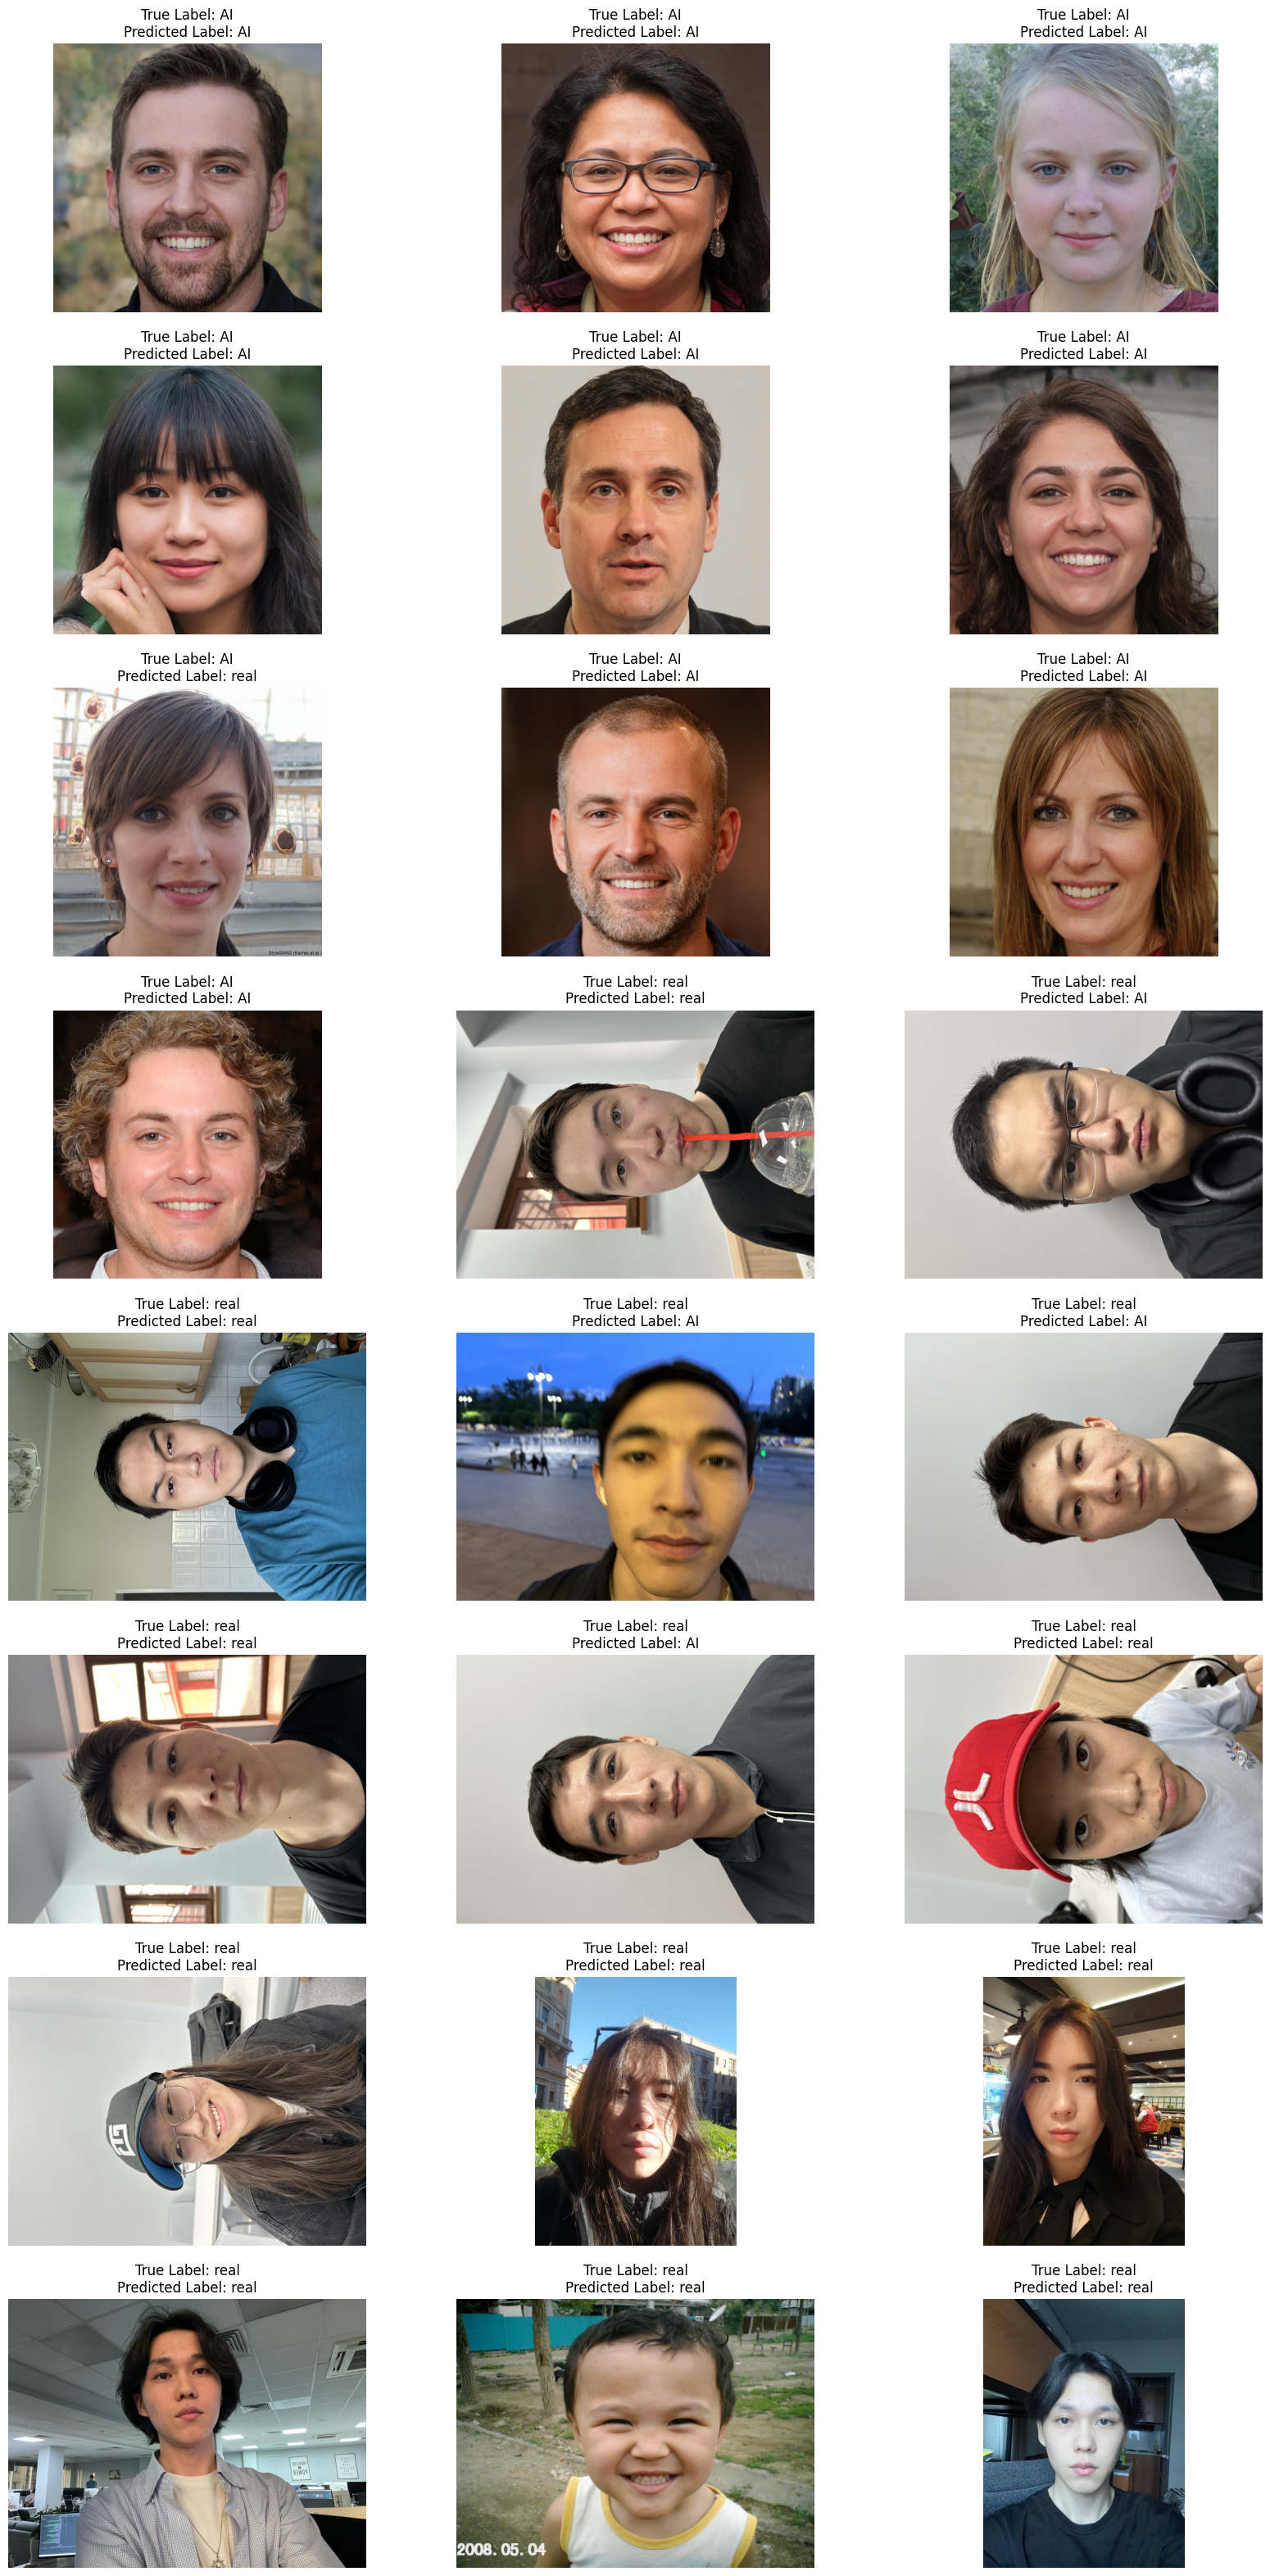

In [ ]:
num_images = len(folder)
num_cols = 3
num_rows = (num_images // num_cols) + (num_images % num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        image_path = os.path.join(path, folder[i])
        true_label = 0 if 'human' in folder[i] else 1
        prediction = predict_image(model, image_path, true_label)

        # Load and display image
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')

        ax.set_title(f"True Label: {'real' if true_label == 0 else 'AI'}\nPredicted Label: {'real' if prediction == 0 else 'AI'}")

plt.show()